In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns

import sklearn
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.model_selection import train_test_split,KFold,cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance, plot_partial_dependence, partial_dependence
import xgboost as xgb

In [40]:
pd.options.display.max_columns = None

In [41]:
def model_checking(ax,model,X,Y):
    y_max = np.max(Y)
    ax.set_xlim([0,y_max])
    ax.set_ylim([0,y_max])
    ax.scatter(model.predict(X),Y,c='k',alpha=0.4,s=X.number_of_reviews)
    ax.plot([0,y_max],[0,y_max],c='r',ls='--')
    ax.set_xlabel('Predicted Price')
    ax.set_ylabel('Listing Price')
    
def model_checking_residual(ax,model,X,Y):
    new_Y = Y - model.predict(X)
    y_max = np.max(new_Y)
    ax.set_ylim([-y_max,y_max])
    ax.scatter(X,new_Y,c='k',alpha=0.4,s=X.number_of_reviews)
    #ax.plot([0,0],[0,0],c='r',ls='--')
    ax.set_xlabel('Listed Price')
    ax.set_ylabel('Residuals')
    
    

In [42]:
df_listing = pd.read_csv('../Data/listings_details.csv')
df_reviews = pd.read_csv('../Data/reviews_Details.csv')
df_scrape = pd.read_csv('../Data/Airbnb_Description.csv')
df_listing.head(5)

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2265,https://www.airbnb.com/rooms/2265,20210210181232,2021-02-12,Zen-East in the Heart of Austin (monthly rental),Zen East is situated in a vibrant & diverse mu...,NaN,https://a0.muscache.com/pictures/4740524/63f82...,2466,https://www.airbnb.com/users/show/2466,Paddy,2008-08-23,"Austin, Texas, United States",I am a long time resident of Austin. I earned ...,within a few hours,100%,90%,f,https://a0.muscache.com/im/users/2466/profile_...,https://a0.muscache.com/im/users/2466/profile_...,East Downtown,3.0,3.0,"['email', 'phone', 'facebook', 'reviews', 'kba']",t,t,NaN,78702,NaN,30.27750,-97.71398,Entire house,Entire home/apt,4,NaN,2 baths,2.0,2.0,"[""Free parking on premises"", ""Hair dryer"", ""Pa...",$200.00,7,180,7.0,7.0,180.0,180.0,7.0,180.0,NaN,t,13,13,42,131,2021-02-12,24,0,0,2009-03-17,2019-03-16,93.0,9.0,10.0,10.0,10.0,8.0,9.0,NaN,f,3,2,1,0,0.17
1,5245,https://www.airbnb.com/rooms/5245,20210210181232,2021-02-12,"Eco friendly, Colorful, Clean, Cozy monthly share",Situated in a vibrant & diverse multicultural ...,NaN,https://a0.muscache.com/pictures/5167505/b33b5...,2466,https://www.airbnb.com/users/show/2466,Paddy,2008-08-23,"Austin, Texas, United States",I am a long time resident of Austin. I earned ...,within a few hours,100%,90%,f,https://a0.muscache.com/im/users/2466/profile_...,https://a0.muscache.com/im/users/2466/profile_...,East Downtown,3.0,3.0,"['email', 'phone', 'facebook', 'reviews', 'kba']",t,t,NaN,78702,NaN,30.27577,-97.71379,Private room in house,Private room,2,NaN,1 private bath,1.0,2.0,"[""Free parking on premises"", ""Hair dryer"", ""Br...",$114.00,30,60,30.0,30.0,60.0,60.0,30.0,60.0,NaN,t,0,0,0,0,2021-02-12,9,0,0,2009-03-19,2018-03-14,91.0,10.0,8.0,10.0,9.0,10.0,9.0,NaN,f,3,2,1,0,0.06
2,5456,https://www.airbnb.com/rooms/5456,20210210181232,2021-02-12,"Walk to 6th, Rainey St and Convention Ctr",Great central location for walking to Convent...,My neighborhood is ideally located if you want...,https://a0.muscache.com/pictures/14084884/b5a3...,8028,https://www.airbnb.com/users/show/8028,Sylvia,2009-02-16,"Austin, Texas, United States",I am a licensed Real Estate Broker and owner o...,within a few hours,100%,91%,t,https://a0.muscache.com/im/users/8028/profile_...,https://a0.muscache.com/im/users/8028/profile_...,East Downtown,1.0,1.0,"['email', 'phone', 'reviews', 'kba']",t,t,"Austin, Texas, United States",78702,NaN,30.26112,-97.73448,Entire guesthouse,Entire home/apt,3,NaN,1 bath,1.0,2.0,"[""Hair dryer"", ""Dishes and silverware"", ""Air c...",$104.00,2,90,2.0,2.0,90.0,90.0,2.0,90.0,NaN,t,24,54,84,354,2021-02-12,543,20,3,2009-03-08,2021-02-01,97.0,10.0,10.0,10.0,10.0,10.0,9.0,NaN,f,1,1,0,0,3.74
3,5636,https://www.a

In [43]:
df_listing.shape

(10272, 74)

## Performing EDA Analysis

In [44]:
# Removing unnecessary columns
columns_to_remove = ['scrape_id','last_scraped','neighbourhood_group_cleansed','calendar_updated','license','bathrooms',
                     'picture_url','host_has_profile_pic','host_name','host_url','host_thumbnail_url','name',
                     'minimum_minimum_nights','maximum_minimum_nights','minimum_maximum_nights','maximum_maximum_nights',
                     'minimum_nights_avg_ntm','maximum_nights_avg_ntm','has_availability','host_picture_url',
                     'number_of_reviews_ltm','calendar_last_scraped',
                     'calculated_host_listings_count','calculated_host_listings_count_entire_homes','calculated_host_listings_count_private_rooms',
                     'calculated_host_listings_count_private_rooms','calculated_host_listings_count_shared_rooms','reviews_per_month',
                     'neighbourhood','host_about'
                     ] 
df_listing.drop(columns_to_remove,axis=1,inplace=True)

### Renaming Columns

In [45]:
df_listing = df_listing.rename(columns={'neighbourhood_cleansed': 'zip_code'})

### Converting the columns data format

In [46]:
df_listing.first_review = pd.to_datetime(df_listing.first_review)
df_listing.last_review = pd.to_datetime(df_listing.last_review)
df_listing.host_since = pd.to_datetime(df_listing.host_since)

df_listing["Timeframe"] = (df_listing.last_review - df_listing.first_review).dt.days
df_listing.drop(['first_review','last_review'],axis=1,inplace=True)

In [47]:
# Filtering the prices and remove the highest ones due to SXSW festival
df_listing.price = df_listing.price.replace('[\$,]','',regex=True).astype(float)
df_listing = df_listing[df_listing.price<5200]

In [48]:
# Converting categories to numbers
df_listing.loc[:,'host_is_superhost'] = df_listing.host_is_superhost.map({'t':1,'f':0})
df_listing.loc[:,'instant_bookable'] = df_listing.instant_bookable.map({'t':1,'f':0})


In [49]:
print(df_listing.price.mean())
print(df_listing.price.median())

241.5359336908825
135.0


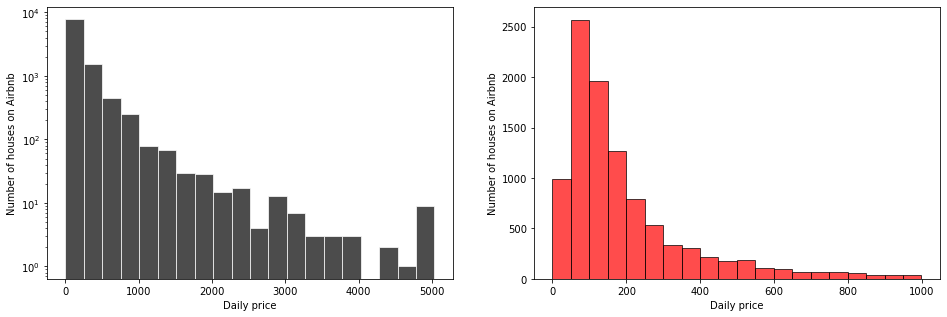

In [50]:
fig,axs = plt.subplots(1,2,figsize=(16,5))
axs[0].hist(df_listing.price,bins=20,color='k',alpha=0.7,edgecolor='w')
axs[0].set_yscale('log');
axs[0].set_xlabel('Daily price');
axs[0].set_ylabel('Number of houses on Airbnb');
axs[0].grid(b='None');
axs[0].grid(None);
axs[1].hist(df_listing.price[df_listing.price<1000],bins=20,color='r',alpha=0.7,edgecolor='k');
axs[1].set_xlabel('Daily price');
axs[1].set_ylabel('Number of houses on Airbnb');
df_listing = df_listing[df_listing.price<2500]

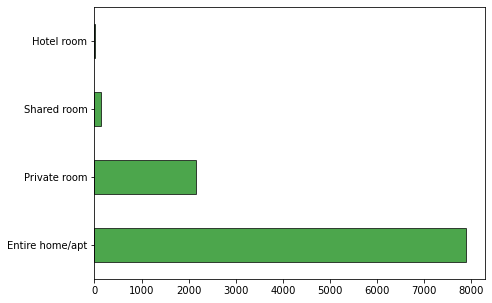

In [51]:
fig,axs = plt.subplots(figsize=(7,5))
df_listing.room_type.value_counts().plot(kind='barh',color='g',alpha=0.7,edgecolor='k');

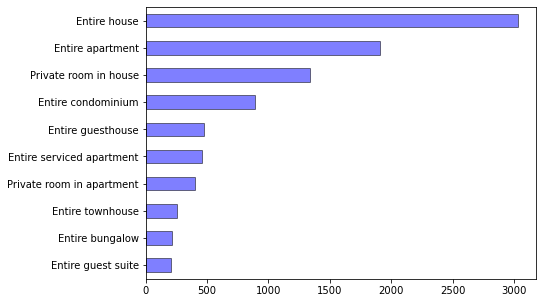

In [52]:
fig,ax = plt.subplots(figsize=(7,5))
df_listing.property_type.value_counts()[:10].sort_values().plot(kind='barh',color='b',alpha=0.5,edgecolor='k');

In [53]:
#df_listing.info()

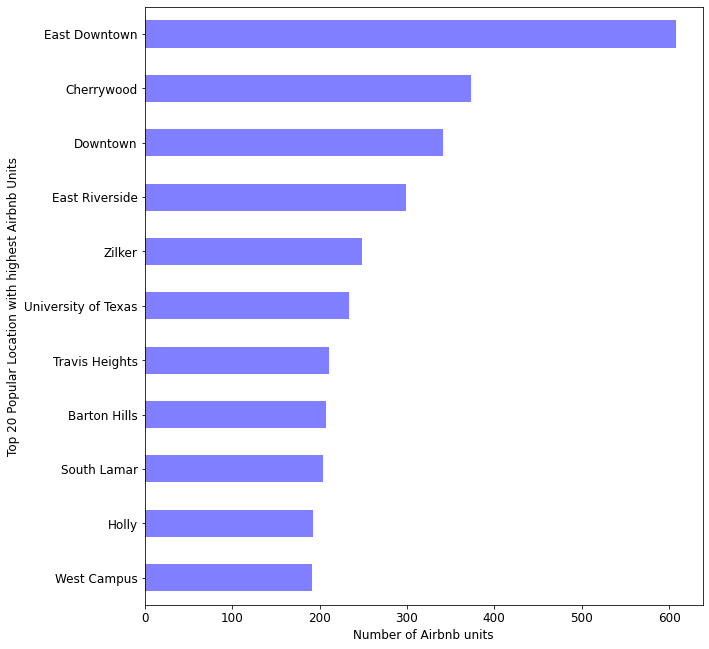

In [54]:
fig,ax = plt.subplots(figsize=(10,11));
ax = df_listing.host_neighbourhood.value_counts()[:11].sort_values().plot.barh(color='b',alpha=0.5);
ax.set_ylabel('Top 20 Popular Location with highest Airbnb Units');
ax.set_xlabel('Number of Airbnb units');
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels() ):
        item.set_fontsize(12)

In [55]:
dict_amenities = dict()
for i,lst in zip(df_listing.amenities.index,df_listing.amenities):
    #if df_listing.price[i]>500:
    for word in lst.replace('[','').replace('"','').replace(']','').replace(' ','').split(','):
        if word not in dict_amenities:
            dict_amenities[word] = 1
        else:
            dict_amenities[word] += 1

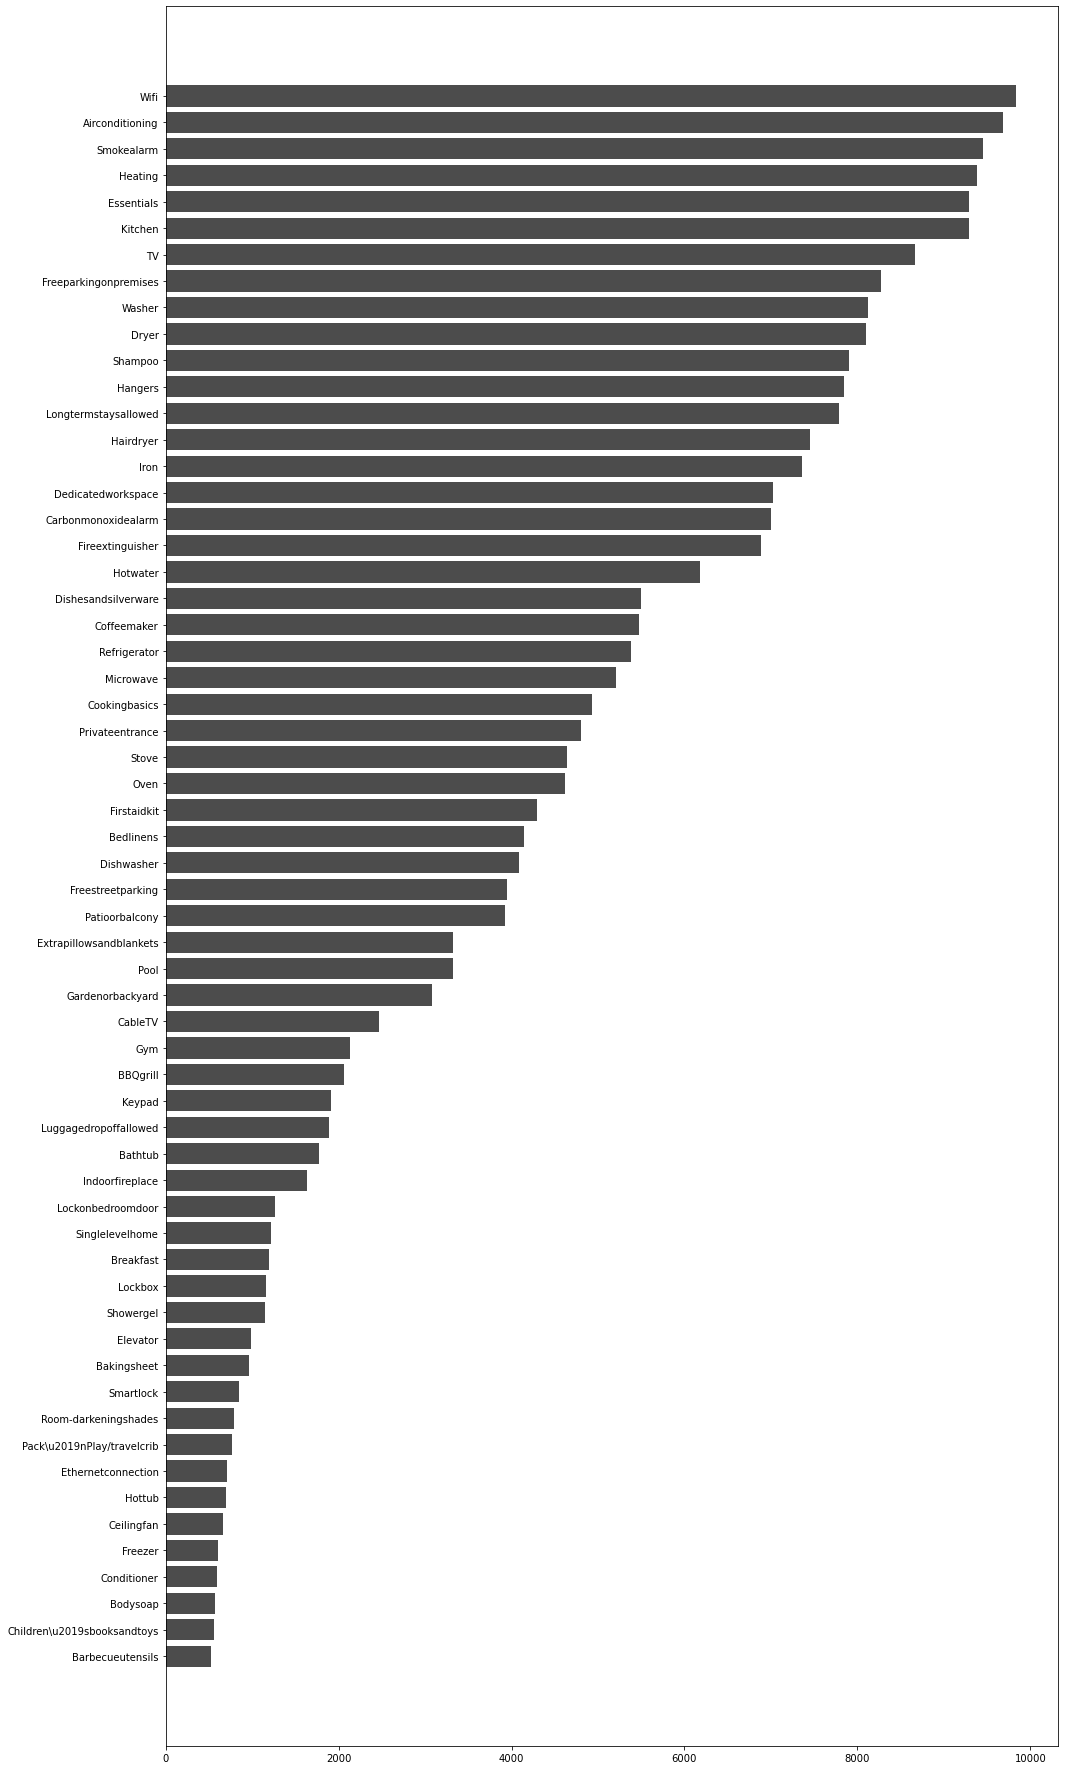

In [56]:
filtered_dict = {k:v for k,v in dict_amenities.items() if v>500}
filtered_dict = {k:v for k,v in sorted(filtered_dict.items(),key=lambda item:item[1])}

fig,ax = plt.subplots(figsize=(16,32))
a= list(filtered_dict.keys())
b= filtered_dict.values()
# ax.bar(a,b)
plt.barh(a,b,color='k',alpha=0.7);

In [57]:
## Features to keep
# bbqgrill, gym, pool,private_entrance

# Most expensive house
# https://www.airbnb.com/rooms/46081394/photos?guests=1&adults=1
# https://www.airbnb.com/luxury/listing/36868497?source_impression_id=p3_1616965432_%2BtiLPpKVsNjbcXS8&guests=1&adults=1&check_in=2021-04-07&check_out=2021-04-10
#https://www.airbnb.com/rooms/46081476/photos?source_impression_id=p3_1616965591_2THtdQLDDHYaRava

Text(0.5, 0, 'Host Locations')

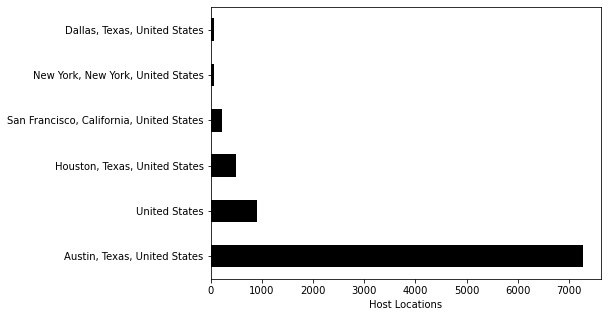

In [58]:
df_listing.host_location = df_listing.host_location.str.replace('US','United States')
fig,ax = plt.subplots(figsize=(7,5))
ax = df_listing.host_location.value_counts().head(6).plot(kind='barh',color='k')
ax.set_xlabel('Host Locations')

Text(0, 0.5, 'Median Price per Night')

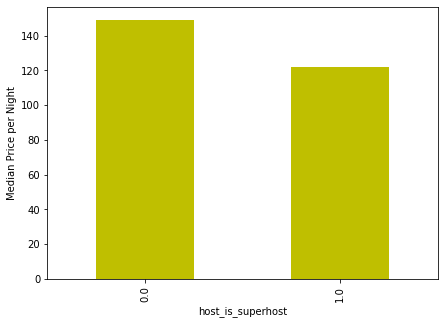

In [59]:
fig,ax = plt.subplots(figsize=(7,5));
df_listing.groupby('host_is_superhost').price.median().plot(kind='bar',color='y');
ax.set_ylabel('Median Price per Night')

In [60]:
df_listing.bedrooms = df_listing.bedrooms.fillna(0)

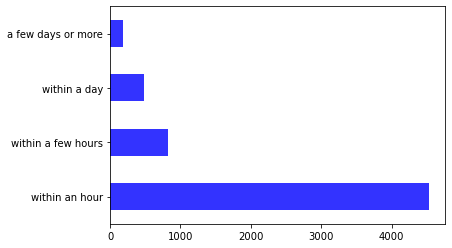

In [61]:
df_listing.host_response_time.value_counts().plot(kind='barh',color='b',alpha=0.8);

In [62]:
columns_to_remove2 = ['host_response_time','host_response_rate','host_neighbourhood'] 
df_listing.drop(columns_to_remove2,axis=1,inplace=True)

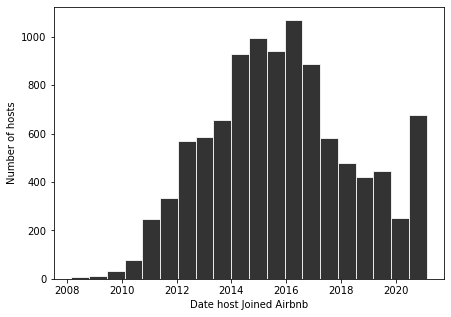

In [63]:
fig,ax = plt.subplots(figsize=(7,5))
df_listing.host_since.hist(bins=20,color='k',alpha=0.8,edgecolor='w')
ax.grid(None);
ax.set_xlabel('Date host Joined Airbnb');
ax.set_ylabel('Number of hosts');

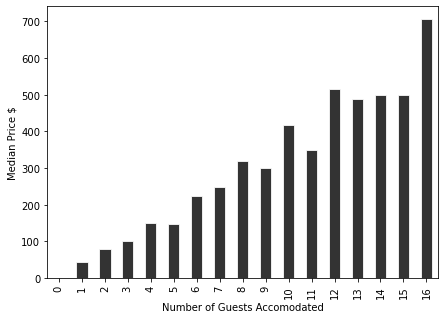

In [64]:
fig,ax = plt.subplots(figsize=(7,5))
ax = df_listing.groupby('accommodates').price.median().plot(kind='bar',color='k',alpha=0.8,edgecolor='w');
ax.set_xlabel('Number of Guests Accomodated');
ax.set_ylabel('Median Price $');

In [65]:
df_listing.room_type = df_listing.room_type.str.replace('Hotel room','Hotel_room')
df_listing.room_type = df_listing.room_type.str.replace('Private room','Private_room')
df_listing.room_type = df_listing.room_type.str.replace('Shared room','Shared_room')

dummies_room_type = pd.get_dummies(df_listing.room_type,prefix='room_type_',drop_first=True)

In [66]:
df_listing = pd.concat([df_listing,dummies_room_type],axis=1)
df_listing.drop('room_type',axis=1,inplace=True)

In [67]:
df_listing.bathrooms_text = df_listing.bathrooms_text.str.replace('1 private bath','1 bath')
df_listing.bathrooms_text = df_listing.bathrooms_text.str.replace('1 shared bath','0.5 bath')
df_listing.bathrooms_text = df_listing.bathrooms_text.str.replace('1.5 shared baths','0.75 bath')
df_listing.bathrooms_text = df_listing.bathrooms_text.str.replace('2 shared baths','1 bath')
df_listing.bathrooms_text = df_listing.bathrooms_text.str.replace('Half-bath','0.5 bath')
df_listing.bathrooms_text = df_listing.bathrooms_text.str.replace('4 shared baths','2 baths')
df_listing.bathrooms_text = df_listing.bathrooms_text.str.replace('2.5 shared baths','1.25 baths')
df_listing.bathrooms_text = df_listing.bathrooms_text.str.replace('3 shared baths','1.5 baths')
df_listing.bathrooms_text = df_listing.bathrooms_text.str.replace('Private half-bath','0.5 bath')
df_listing.bathrooms_text = df_listing.bathrooms_text.str.replace('0 shared baths','0 bath')
df_listing.bathrooms_text = df_listing.bathrooms_text.str.replace('2 bath','2 baths')
df_listing.bathrooms_text = df_listing.bathrooms_text.str.replace('0 baths','0 bath')
df_listing = df_listing[df_listing.bathrooms_text.notnull()]
df_listing['bathrooms'] = df_listing.bathrooms_text.apply(lambda x:float(x.split(' ')[0]))
df_listing.drop('bathrooms_text',axis=1,inplace=True)

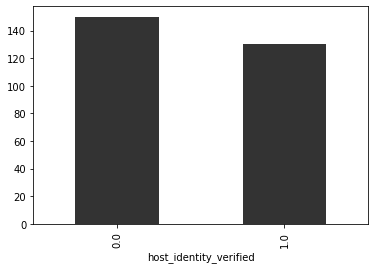

In [68]:
df_listing.loc[:,'host_identity_verified'] = df_listing.host_identity_verified.map({'t':1,'f':0});
df_listing.groupby('host_identity_verified').price.median().plot(kind='bar',color='k',alpha=0.8);

In [69]:
df_listing.drop('host_identity_verified',axis=1,inplace=True)
df_listing.drop('description',axis=1,inplace=True)
df_listing.drop('neighborhood_overview',axis=1,inplace=True)

In [70]:
property_type = ['Entire house','Entire apartment','Private room in house','Entire condominium','Entire guesthouse',             
'Entire serviced apartment','Private room in apartment','Entire townhouse','Entire bungalow','Entire guest suite']
df_listing.property_type = df_listing.property_type.apply(lambda x: 'other' if x not in property_type else x)
dummies_property_type = pd.get_dummies(df_listing.property_type,prefix='property_type',drop_first=True)
df_listing = pd.concat([df_listing,dummies_property_type],axis=1)
df_listing.drop('property_type',axis=1,inplace=True)

df_listing = df_listing.rename(columns={'neighbourhood_cleansed': 'zip_code',
                                        'property_type_Entire bungalow':'property_type_Entire_bungalow',                    
                                        'property_type_Entire condominium':'property_type_Entire_condominium',                
                                        'property_type_Entire guest suite':'property_type_Entire_guest_suite',             
                                        'property_type_Entire guesthouse': 'property_type_Entire_guesthouse',            
                                        'property_type_Entire house':'property_type_Entire_house',                      
                                        'property_type_Entire serviced apartment':'property_type_Entire_serviced_apartment',       
                                        'property_type_Entire townhouse':'property_type_Entire_townhouse',                  
                                        'property_type_Private room in apartment':'property_type_Private_room_in_apartment',        
                                        'property_type_Private room in house': 'property_type_Private_room_in_house'    
                                       })

In [71]:
df_listing[['availability_30','availability_60','availability_90']]

,availability_30,availability_60,availability_90
0,13,13,42
1,0,0,0
2,24,54,84
3,7,37,67
4,21,50,79
...,...,...,...
10267,0,0,29
10268,0,26,56
10269,25,55,85
10270,0,19,49


In [72]:
## ?? Make Zip code dummies
zip_list = [78702,78704,78734,78746,78703]
df_listing.zip_code = df_listing.zip_code.apply(lambda x: x if x in zip_list else 78000)
dummies_zip_code = pd.get_dummies(df_listing.zip_code,prefix='zipcode',drop_first=True)
df_listing = pd.concat([df_listing,dummies_zip_code],axis=1)
df_listing.drop('zip_code',axis=1,inplace=True)

# df_listing.boxplot(column=['price'],by='zip_code', figsize = (20,20), grid=False) 

In [73]:
df_listing['pool'] = df_listing.amenities.apply(lambda x: 1 if 'pool' in x.lower() else 0)
df_listing['tv'] = df_listing.amenities.apply(lambda x: 1 if 'tv' in x.lower() else 0)
df_listing['washer'] = df_listing.amenities.apply(lambda x: 1 if 'washer' in x.lower() else 0)
df_listing['dryer'] = df_listing.amenities.apply(lambda x: 1 if 'dryer' in x.lower() else 0)
df_listing['balcony'] = df_listing.amenities.apply(lambda x: 1 if 'balcony' in x.lower() else 0)
df_listing['entrance'] = df_listing.amenities.apply(lambda x: 1 if 'entrance' in x.lower() else 0)
df_listing['bbq'] = df_listing.amenities.apply(lambda x: 1 if 'bbq' in x.lower() else 0)
df_listing['hottub'] = df_listing.amenities.apply(lambda x: 1 if 'hot' in x.lower() else 0)
df_listing['singlelevelhome']=df_listing.amenities.apply(lambda x: 1 if 'level' in x.lower() else 0)

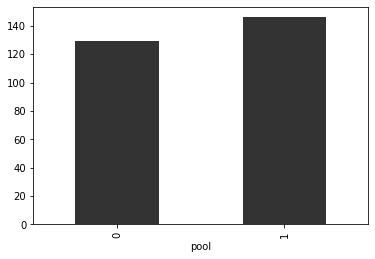

In [74]:
df_listing.groupby('pool').price.median().plot(kind='bar',color='k',alpha=0.8);

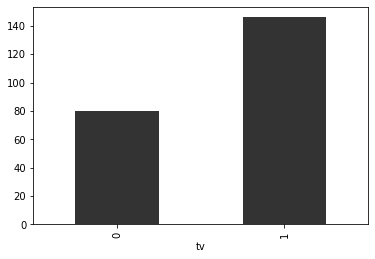

In [75]:
df_listing.groupby('tv').price.median().plot(kind='bar',color='k',alpha=0.8);

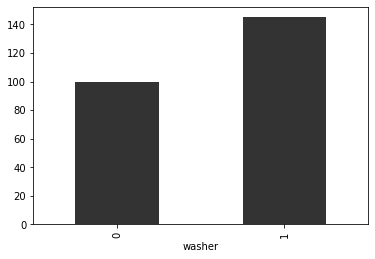

In [76]:
df_listing.groupby('washer').price.median().plot(kind='bar',color='k',alpha=0.8);

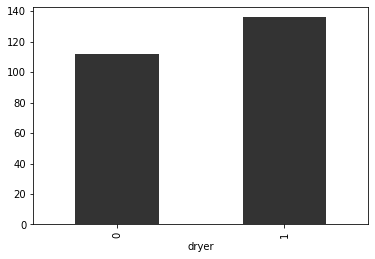

In [77]:
df_listing.groupby('dryer').price.median().plot(kind='bar',color='k',alpha=0.8);

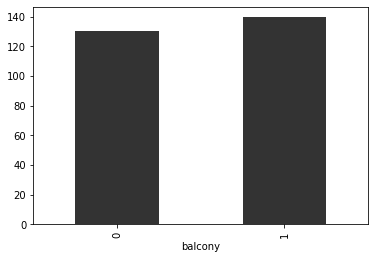

In [78]:
df_listing.groupby('balcony').price.median().plot(kind='bar',color='k',alpha=0.8);

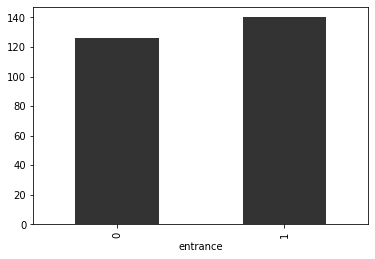

In [79]:
df_listing.groupby('entrance').price.median().plot(kind='bar',color='k',alpha=0.8);

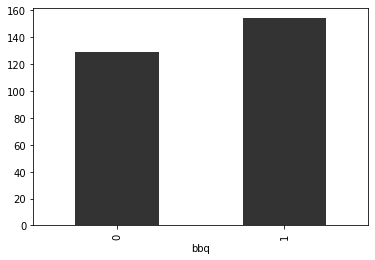

In [80]:
df_listing.groupby('bbq').price.median().plot(kind='bar',color='k',alpha=0.8);

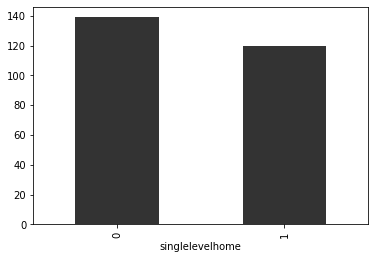

In [81]:
df_listing.groupby('singlelevelhome').price.median().plot(kind='bar',color='k',alpha=0.8);

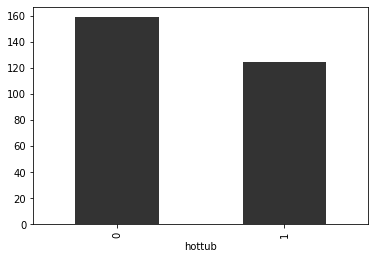

In [82]:
#fig,axs =plt.subplots(1,2,figsize=(12,4))
df_listing.groupby('hottub').price.median().plot(kind='bar',color='k',alpha=0.8);


In [83]:
df_listing.beds.fillna(value=0,inplace=True)
df_listing = df_listing[df_listing.host_is_superhost.notna()]
df_listing.Timeframe.fillna(value=0,inplace=True)

In [84]:
#df_listing.review_scores_rating.fillna(90,inplace=True)

In [85]:
df_listing.host_acceptance_rate = df_listing.host_acceptance_rate.replace('[%]','',regex=True).astype(float)

df_scrape.cleaning_fee = df_scrape.cleaning_fee.replace('[$]','',regex=True).astype(float)

In [86]:
df_scrape.rename(columns={'link':'listing_url'},inplace=True)

In [87]:
df_listing = pd.merge(left=df_listing,right=df_scrape[['listing_url','cleanliness', 'Accuracy', 'Communication', 'Location',
       'Checkin', 'Value', 'Final_score','cleaning_fee']],on='listing_url')

# Machine Learning Section

### Linear Regression

In [88]:
df_listing.columns

Index(['id', 'listing_url', 'host_id', 'host_since', 'host_location',
       'host_acceptance_rate', 'host_is_superhost', 'host_listings_count',
       'host_total_listings_count', 'host_verifications', 'latitude',
       'longitude', 'accommodates', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'number_of_reviews', 'number_of_reviews_l30d', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'instant_bookable',
       'Timeframe', 'room_type__Hotel_room', 'room_type__Private_room',
       'room_type__Shared_room', 'bathrooms', 'property_type_Entire_bungalow',
       'property_type_Entire_condominium', 'property_type_Entire_guest_suite',
       'property_type_Entire_guesthouse', 'property_type_Entire_house',

### Features to Consider

In [89]:
features =['host_is_superhost', 'host_listings_count',
           'host_total_listings_count',
           'accommodates', 'bedrooms', 'beds',
           'minimum_nights', 'maximum_nights', 'availability_90','availability_365',
           'number_of_reviews', 'number_of_reviews_l30d',
           'instant_bookable', 'Timeframe',
           'room_type__Private_room',
           'bathrooms', 
           'cleanliness', 'Accuracy', 'Communication','Location', 'Checkin', 'Value','Final_score',
           'pool','tv','washer','dryer','balcony','entrance','bbq','hottub','singlelevelhome',
           'zipcode_78702', 'zipcode_78703', 'zipcode_78704', 'zipcode_78734',
           'zipcode_78746',
           'property_type_Entire_house']


# features =['host_is_superhost', 'host_listings_count',
#            'host_total_listings_count',  'zip_code',
#            'accommodates', 'bedrooms', 'beds',
#            'minimum_nights', 'maximum_nights', 'availability_90',
#            'number_of_reviews', 'review_scores_rating', 'instant_bookable', 'Timeframe',
#            'room_type__Hotel_room', 'room_type__Private_room',
#            'room_type__Shared_room', 'bathrooms', 'property_type_Entire_bungalow',
#            'property_type_Entire_condominium', 'property_type_Entire_guest_suite',
#            'property_type_Entire_guesthouse', 'property_type_Entire_house',
#            'property_type_Entire_serviced_apartment',
#            'property_type_Entire_townhouse',
#            'property_type_Private_room_in_apartment',
#            'property_type_Private_room_in_house', 'property_type_other', 'pool',
#            'tv', 'washer', 'dryer', 'balcony', 'entrance', 'bbq','hottub','singlelevelhome']
df_listing = df_listing[df_listing.Final_score!=0]

X = df_listing[features]
y= df_listing.price
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1)

In [90]:
# cor_feature = []
# cor_feature = features.copy()
# cor_feature.append('price')
# # X_Corr = df_listing[features.append('price')];
# fig,ax = plt.subplots(figsize=(30,30));
# sns.heatmap(df_listing[cor_feature].corr(),annot=True,cmap='BrBG');

In [91]:
lr = LinearRegression()
lr.fit(X_train,y_train)

LinearRegression()

In [92]:
cross_val_score(lr,X_train,y_train).mean()

0.5840476955340852

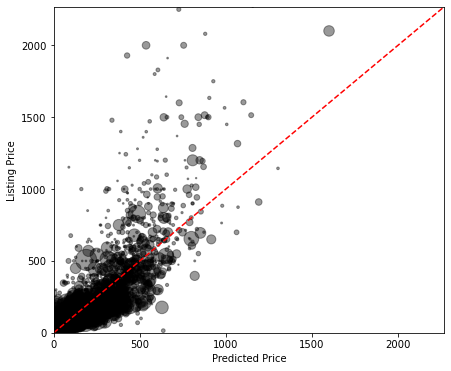

In [93]:
X_trial=[0,800]
y_trial=[0,800]
fig,ax = plt.subplots(figsize=(7,6));
model_checking(ax,lr,X_train,y_train)

In [94]:
y_test_predict = lr.predict(X_test)
r2_score(y_test,y_test_predict)

0.546491776375082

In [95]:
g = pd.concat([X_train,y_train],axis=1);
g.columns
gg = g[['accommodates', 'bedrooms', 'beds', 'minimum_nights',
       'maximum_nights', 'availability_90', 'number_of_reviews',
       'bathrooms','Value', 'price']]

In [96]:
#pd.plotting.scatter_matrix(gg,alpha=0.6,figsize=(20,20),diagonal='kde',c='k');

In [97]:
ss = StandardScaler()
ss.fit(X_train)
X_train_s = ss.transform(X_train)
X_test_s = ss.transform(X_test)
lasso = Lasso(alpha=0.1)
lasso.fit(X_train_s,y_train)
y_prediction = lasso.predict(X_test_s)
print('test',r2_score(y_test,y_prediction))
print('train',r2_score(y_train,lasso.predict(X_train_s)))

test 0.5462760136756306
train 0.5982150930698702


### Random Forest

In [98]:
rf = RandomForestRegressor(n_estimators=1000,max_depth=10,n_jobs=-1)
rf.fit(X_train,y_train)
cross_val_score(rf,X_train,y_train,scoring='r2').mean()
#r2_score(y_train,rf.predict(X_train))

0.6333867536973442

In [99]:
y_predicted = rf.predict(X_test)

In [100]:
r2_score(y_test,y_predicted)

0.5873366795575719

In [101]:
rf = RandomForestRegressor(max_depth=15,n_estimators = 1250,max_features=10)
cross_val_score(rf,X_train,y_train).mean()

0.6510647924237479

In [102]:
(-cross_val_score(rf,X_train,y_train,scoring='neg_root_mean_squared_error')).mean()

127.97562702001076

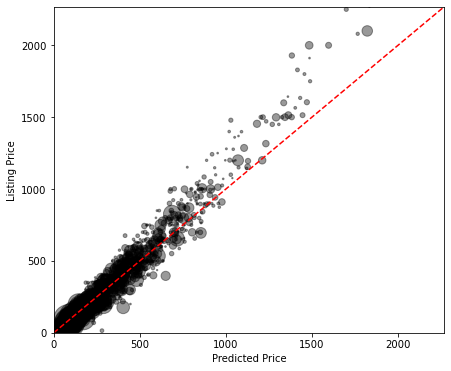

In [103]:
# Training dataset
rf.fit(X_train,y_train)
fig,ax = plt.subplots(figsize=(7,6))
model_checking(ax,rf,X_train,y_train);

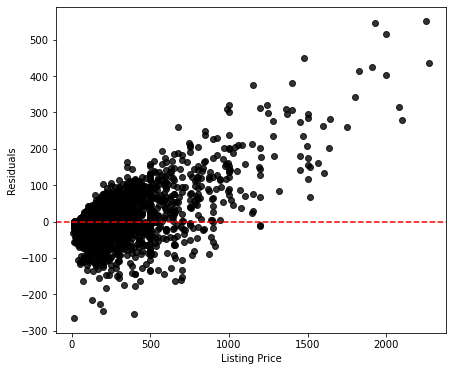

In [104]:
fig,ax = plt.subplots(figsize=(7,6))
y_residual = y_train - rf.predict(X_train)
ax.scatter(y_train,y_residual,c='k',alpha=0.8);
ax.axhline(0,color='r',ls='--');
ax.set_ylabel('Residuals');
ax.set_xlabel('Listing Price');

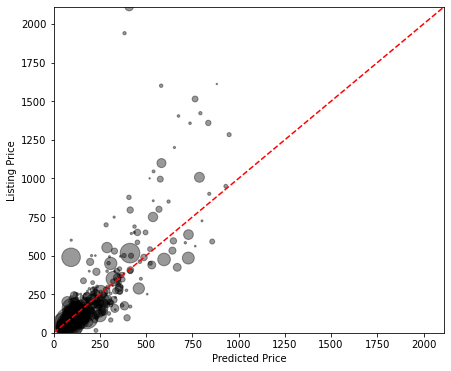

In [105]:
# Testing dataset
fig,ax = plt.subplots(figsize=(7,6))
model_checking(ax,rf,X_test,y_test);

### Improving the model

In [106]:
features =['host_is_superhost', 'host_listings_count',
           'host_total_listings_count',
           'accommodates', 'bedrooms', 'beds',
           'minimum_nights', 'maximum_nights', 'availability_90',#'availability_365',
           'number_of_reviews', 'number_of_reviews_l30d',
           'instant_bookable', 'Timeframe',
           'room_type__Private_room',
           'bathrooms', 
           'cleanliness', 'Accuracy', 'Communication', 'Checkin', 'Value',
           'pool','tv','washer','dryer','balcony','entrance','bbq','hottub','singlelevelhome',
           'zipcode_78702', 'zipcode_78703', 'zipcode_78704', 'zipcode_78734',
           'zipcode_78746',
           'property_type_Entire_house']

# features =['host_is_superhost', 'host_listings_count',
#            'host_total_listings_count',
#            'accommodates', 'bedrooms', 'beds',
#            'minimum_nights', 'maximum_nights', 'availability_90','availability_365',
#            'number_of_reviews', 'number_of_reviews_l30d',
#            'instant_bookable', 'Timeframe',
#            'room_type__Private_room',
#            'bathrooms', 
#            'cleanliness', 'Accuracy', 'Communication','Location', 'Checkin', 'Value','Final_score',
#            'pool','tv','washer','dryer','balcony','entrance','bbq','hottub','singlelevelhome',
#            'zipcode_78702', 'zipcode_78703', 'zipcode_78704', 'zipcode_78734',
#            'zipcode_78746',
#            'property_type_Entire_house']

df_listing = df_listing[df_listing.Final_score!=0]
df_listing.shape

(5483, 70)

In [107]:
df_listing_new = df_listing[~((df_listing.availability_90<40)&(df_listing.price>200)&
                              (df_listing.number_of_reviews_l30d<2))]
df_listing_new.shape

(4832, 70)

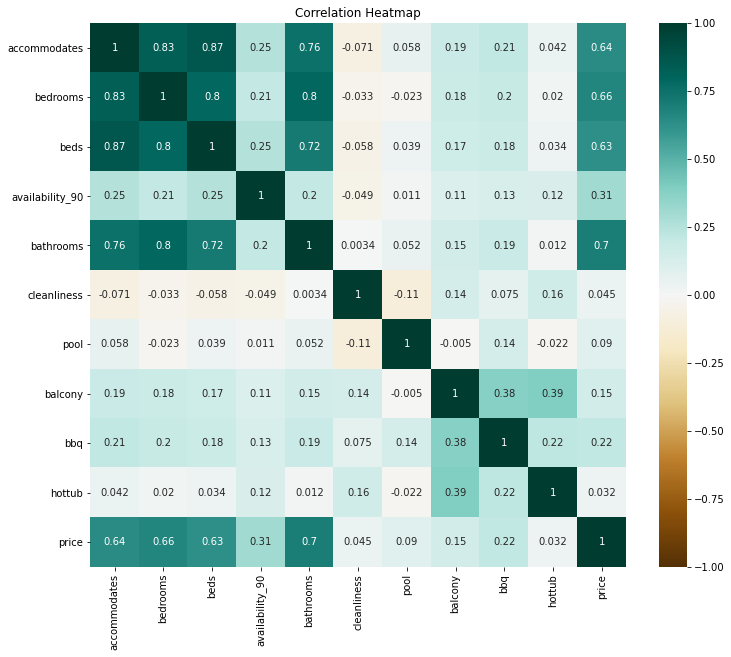

In [108]:
features2 = ['accommodates', 'bedrooms', 'beds',
             'availability_90', 'bathrooms', 
             'cleanliness', 'pool','balcony',
             'bbq','hottub','price']


plt.figure(figsize=(12, 10))
heatmap = sns.heatmap(df_listing_new[features2].corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap');

In [109]:
X = df_listing_new[features]
y= df_listing_new.price
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1)
X.shape

(4832, 35)

In [110]:
rf = RandomForestRegressor(max_depth=15,n_estimators = 1250,max_features=10)
rf.fit(X_train,y_train)

RandomForestRegressor(max_depth=15, max_features=10, n_estimators=1250)

In [111]:
cross_val_score(rf,X_train,y_train).mean()

0.6997306794976399

In [112]:
np.sqrt(mean_squared_error(y_train,rf.predict(X_train)))

41.684525716049414

In [113]:
np.sqrt(mean_squared_error(y_test,rf.predict(X_test)))

121.78488991169132

In [114]:
np.mean(np.abs((y_train-rf.predict(X_train))/y_train))

0.19893645184811548

In [115]:
np.mean(np.abs((y_test-rf.predict(X_test))/y_test))

0.3268087307281851

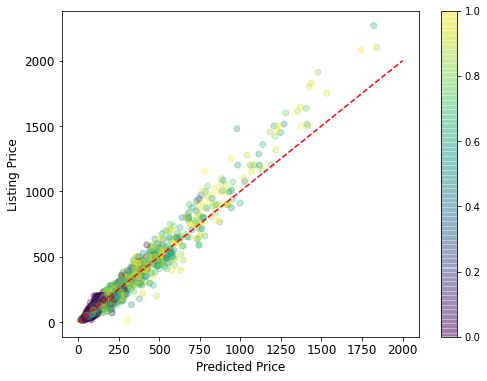

In [116]:
rf.fit(X_train,y_train)
fig,ax = plt.subplots(figsize=(8,6));
normalized_availability = X_train.availability_90/90;
im = ax.scatter(rf.predict(X_train),y_train,c=normalized_availability,alpha=0.3);
ax.plot([0,2000],[0,2000],color='r',ls='--');
ax.set_xlabel('Predicted Price');
ax.set_ylabel('Listing Price');
fig.colorbar(im, ax=ax);
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels() ):
    item.set_fontsize(12)

In [117]:
# X_train[rf.predict(X_train)+400<y_train]

In [118]:
# y_train[rf.predict(X_train)+400<y_train]

In [119]:
# rf.predict(X_train)[rf.predict(X_train)+400<y_train]

In [120]:
# # df_listing_new[(df_listing_new.accommodates==10)&(df_listing_new.number_of_reviews==15)]
# df_listing_new[(df_listing_new.index==3968)|(df_listing_new.index==3000)]

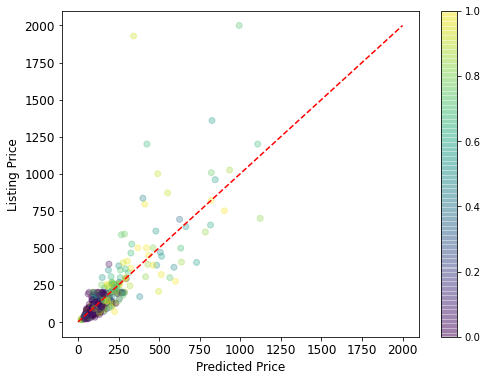

In [121]:
fig,ax = plt.subplots(figsize=(8,6));
normalized_availability = X_test.availability_90/90;
im = ax.scatter(rf.predict(X_test),y_test,c=normalized_availability,alpha=0.3);
ax.plot([0,2000],[0,2000],color='r',ls='--');
ax.set_xlabel('Predicted Price');
ax.set_ylabel('Listing Price');
fig.colorbar(im, ax=ax);
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels() ):
    item.set_fontsize(12)

In [122]:
# X_test[rf.predict(X_test)+600<y_test]

In [123]:
# y_test[rf.predict(X_test)+600<y_test]

In [124]:
# rf.predict(X_test)[rf.predict(X_test)+600<y_test]

In [125]:
# # df_listing_new[(df_listing_new.accommodates==10)&(df_listing_new.number_of_reviews==15)]
# df_listing_new[(df_listing_new.index==4905)|(df_listing_new.index==6416)]

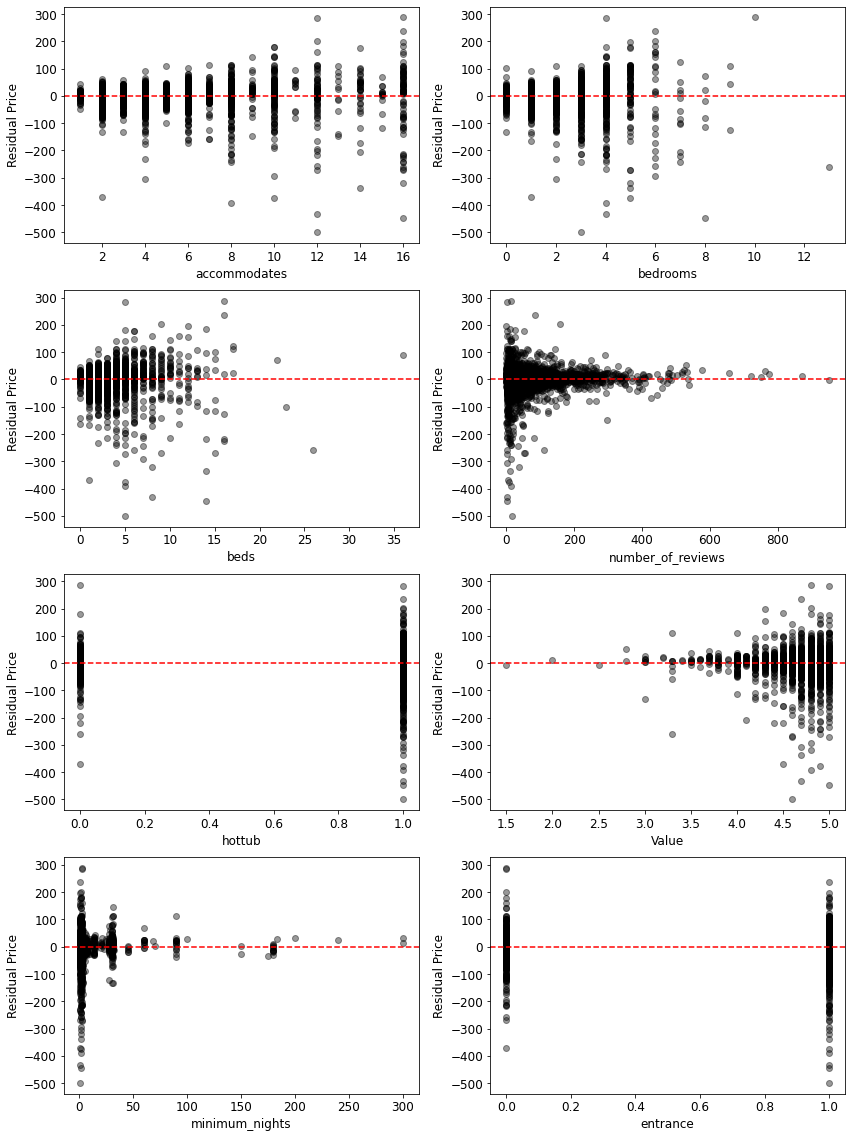

In [126]:
Residuals = rf.predict(X_train)-y_train
fig,axs = plt.subplots(4,2,figsize=(14,20))

lst=['accommodates','bedrooms','beds','number_of_reviews','hottub','Value','minimum_nights','entrance']
normalized_availability = X_train.availability_90/90;

for i,ax in enumerate(axs.ravel()):
#     im = ax.scatter(X_train[lst[i]],Residuals,c=normalized_availability,alpha=0.4)
    im = ax.scatter(X_train[lst[i]],Residuals,c='k',alpha=0.4)
    ax.set_xlabel(lst[i])
    ax.set_ylabel('Residual Price')
    ax.axhline(0,color='r',ls='--')
#    fig.colorbar(im,ax=ax)
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels() ):
        item.set_fontsize(12)

In [127]:
np.sum(np.abs(((y_test-rf.predict(X_test))/y_test)))/len(y_test)

0.3274186949294875

In [128]:
r2_score(y_test,rf.predict(X_test))

0.6595791202664971

In [129]:
r2_score(y_train,rf.predict(X_train))

0.9533546611598135

In [130]:
rf = RandomForestRegressor(max_depth=32,n_estimators = 1250,max_features=8,max_leaf_nodes=32,min_samples_split=4)
rf.fit(X_train,y_train)

RandomForestRegressor(max_depth=32, max_features=8, max_leaf_nodes=32,
                      min_samples_split=4, n_estimators=1250)

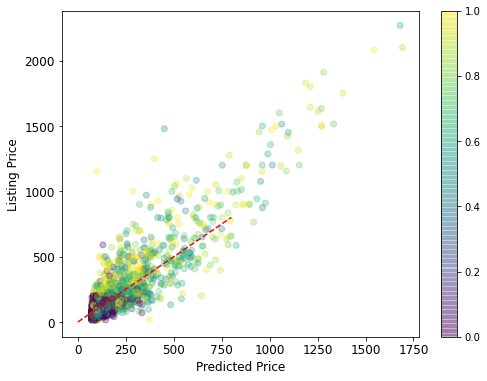

In [131]:
fig,ax = plt.subplots(figsize=(8,6));
normalized_availability = X_train.availability_90/90;
im = ax.scatter(rf.predict(X_train),y_train,c=normalized_availability,alpha=0.3);
ax.plot([0,800],[0,800],color='r',ls='--');
ax.set_xlabel('Predicted Price');
ax.set_ylabel('Listing Price');
fig.colorbar(im, ax=ax);
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels() ):
        item.set_fontsize(12)

In [132]:
# # Changing the number of features
# feature_range = list(range(1,16))
# scores=[]
# for i in feature_range:
#     rf_features = RandomForestRegressor(max_features=i,n_jobs=-1)
#     score = (-cross_val_score(rf_features,X_train,y_train,scoring='neg_mean_squared_error')).mean()
#     scores.append(score)
# fig,ax = plt.subplots();
# ax.plot(feature_range,scores,color='k');

In [133]:
# # Changing the number of trees
# trees_numbers =[500,750,1000,1250,1500,1750,2000]
# scores=[]
# for number in trees_numbers:
#     rf_trees = RandomForestRegressor(n_estimators = number ,n_jobs=-1)
#     score = cross_val_score(rf_trees,X_train,y_train,scoring='neg_root_mean_squared_error').mean()
#     scores.append(score)
# fig,ax = plt.subplots();
# ax.plot(trees_numbers,scores,color='k');

In [134]:
# GRIDCV Search
model = RandomForestRegressor(n_estimators=1500)

grid = {'max_depth': [4,8,16,24,32],
        'min_samples_split':[2,4,8,16],
        'max_features': [4,8,16,32],
        'max_leaf_nodes':[4,8,16,32]}
    
gb_gridsearch = GridSearchCV(estimator=model, param_grid=grid, 
                             cv=5, verbose=0, return_train_score=True, n_jobs=-1)

gb_gridsearch.fit(X_train, y_train)

df_gridsearch = pd.DataFrame(gb_gridsearch.cv_results_)

In [135]:
df_gridsearch.shape

(320, 24)

In [136]:
df_gridsearch[(df_gridsearch.mean_train_score>0.6)&(df_gridsearch.mean_test_score>0.65)]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_max_leaf_nodes,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
92,7.211458,0.022498,0.229737,0.006493,8,8,32,2,"{'max_depth': 8, 'max_features': 8, 'max_leaf_...",0.684182,0.625042,0.690199,0.650922,0.631273,0.656324,0.026679,42,0.779153,0.803401,0.791616,0.800326,0.797427,0.794385,0.008550
93,7.254725,0.039431,0.231834,0.007543,8,8,32,4,"{'max_depth': 8, 'max_features': 8, 'max_leaf_...",0.686862,0.626652,0.686330,0.650874,0.629760,0.656095,0.026262,44,0.778196,0.802925,0.790958,0.798326,0.796998,0.793481,0.008544
94,7.370248,0.028756,0.235851,0.007285,8,8,32,8,"{'max_depth': 8, 'max_features': 8, 'max_leaf_...",0.689309,0.627979,0.692784,0.655060,0.632951,0.659617,0.027256,38,0.773178,0.797620,0.786570,0.793091,0.791625,0.788417,0.008396
95,7.681006,0.043703,0.237452,0.009752,8,8,32,16,"{'max_depth': 8, 'max_features': 8, 'max_leaf_...",0.689157,0.632682,0.695886,0.659507,0.633412,0.662129,0.026716,36,0.755221,0.779763,0.768661,0.775451,0.775615,0.770942,0.008629
108,10.836044,0.013005,0.227505,0.006013,8,16,32,2,"{'max_depth': 8, 'max_features': 16, 'max_leaf...",0.703174,0.625341,0.693917,0.657854,0.643001,0.664657,0.029667,30,0.799479,0.823850,0.813022,0.819816,0.816518,0.814537,0.008337
109,10.888997,0.041713,0.229713,0.009883,8,16,32,4,"{'max_depth': 8, 'max_features': 16, 'max_leaf...",0.702290,0.622331,0.697560,0.659528,0.643538,0.665049,0.030861,27,0.797427,0.823444,0.812753,0.817683,0.815319,0.813325,0.008700
110,11.028105,0.021294,0.229700,0.008255,8,16,32,8,"{'max_depth': 8, 'max_features': 16, 'max_leaf...",0.709569,0.626564,0.695676,0.659922,0.642953,0.666937,0.031298,14,0.793256,0.818668,0.808535,0.814368,0.811648,0.809295,0.008683
111,11.530631,0.052572,0.229498,0.006488,8,16,32,16,"{'max_depth': 8, 'max_features': 16, 'max_leaf...",0.710748,0.626758,0.700098,0.666061,0.640835,0.668900,0.032546,2,0.772260,0.799176,0.789623,0.793860,0.794540,0.789892,0.009322
124,18.472293,0.128390,0.223100,0.006290,8,32,32,2,"{'max_depth': 8, 'max_features': 32, 'max_leaf...",0.713313,0.608399,0.697740,0.656977,0.653549,0.665996,0.036879,19,0.810338,0.834505,0.824697,0.829343,0.826659,0.825108,0.008087
125,18.501185,0.201532,0.226216,0.008867,8,32,32,4,"{'max_depth': 8, 'max_features': 32, 'max_leaf...",0.710320,0.612746,0.696876,0.658687,0.656134,0.666953,0.034351,13,0.809466,0.834353,0.822921,0.828866,0.825559,0.824233,0.008312


In [137]:
# After Gridsearch
# max_depth=8
#max_feature = 8
# max_leaf_node = 32
#min_sample_split 2
# train score 0.74
# test score 0.65


## Feature importnace 

In [138]:
rf = RandomForestRegressor(n_estimators=1000,max_features=10,n_jobs=-1,oob_score=True)
rf.fit(X_train,y_train)
rf.oob_score_

0.7107646520699598

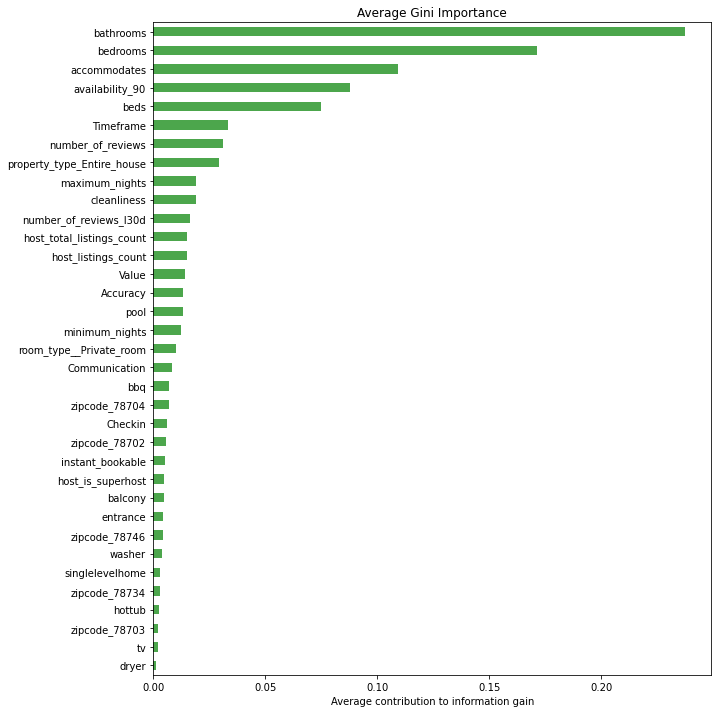

In [139]:
# Plot the feature importance
feat_scores = pd.Series(rf.feature_importances_,
                           index=X.columns)
feat_scores = feat_scores.sort_values()
ax = feat_scores.plot(kind='barh', 
                      figsize=(10,12),
                      color='g',alpha=0.7)
ax.set_title('Average Gini Importance')
ax.set_xlabel('Average contribution to information gain');

In [140]:
# Permutation importance
result = permutation_importance(rf,X_test,y_test,n_jobs=2,n_repeats=10)

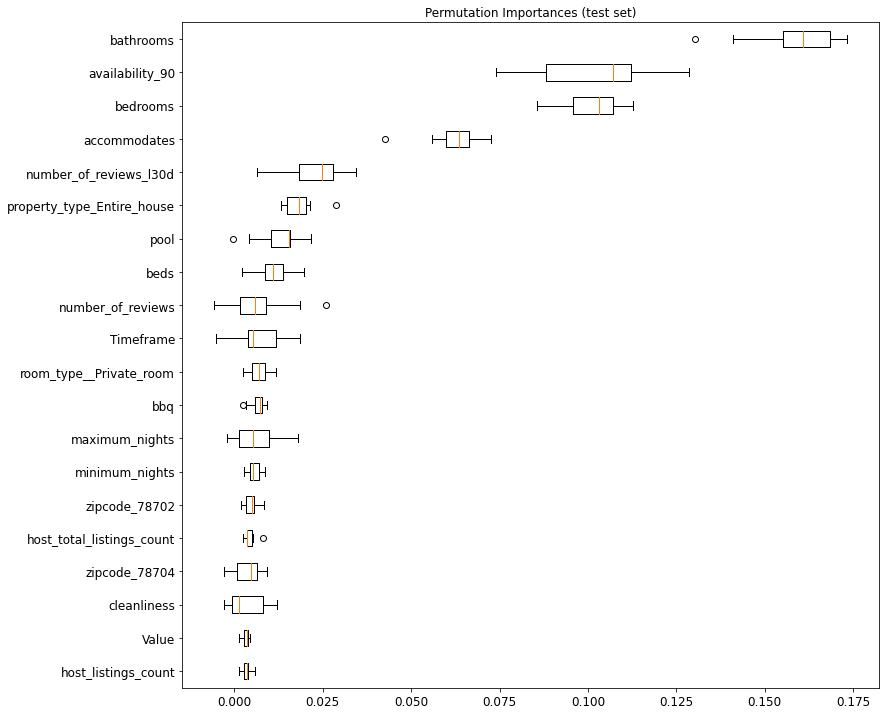

In [141]:
sorted_idx = result.importances_mean.argsort()[-20:]
fig, ax = plt.subplots(figsize=(12,10))
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels() ):
    item.set_fontsize(12)
plt.show()

In [142]:
# Plotting Partial Dependence Plot 
# fig, ax = plt.subplots(figsize=(18,18))
# plot_partial_dependence(rf, X_train, [3,4,5,6,7,8,9,10,11,12,13,14,15,16,17],target=1, ax=ax)
# fig.tight_layout()

### Gradient Boost 

In [143]:
gb_model = GradientBoostingRegressor(learning_rate=0.01,n_estimators=2000)

grid = {'max_depth':[2,4,8,12,16,24],
        'min_samples_split':[2,4,6,8,10]}

In [144]:
gb_gridsearch = GridSearchCV(estimator=gb_model, param_grid=grid, 
                             cv=5, verbose=0, n_jobs=-1 , return_train_score=True)

gb_gridsearch.fit(X_train, y_train)

/home/ali/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


GridSearchCV(cv=5,
             estimator=GradientBoostingRegressor(learning_rate=0.01,
                                                 n_estimators=2000),
             n_jobs=-1,
             param_grid={'max_depth': [2, 4, 8, 12, 16, 24],
                         'min_samples_split': [2, 4, 6, 8, 10]},
             return_train_score=True)

In [145]:
df_gridsearch = pd.DataFrame(gb_gridsearch.cv_results_)

In [146]:
df_gridsearch.head(20)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,13.669896,0.022408,0.028157,0.000534,2,2,"{'max_depth': 2, 'min_samples_split': 2}",0.702989,0.646652,0.673376,0.680171,0.691426,0.678923,0.019022,7,0.776758,0.807246,0.800170,0.799219,0.796361,0.795951,1.024315e-02
1,13.704351,0.051539,0.027929,0.000417,2,4,"{'max_depth': 2, 'min_samples_split': 4}",0.702995,0.646586,0.673940,0.680373,0.690242,0.678827,0.018869,8,0.776758,0.807016,0.800088,0.799339,0.795830,0.795806,1.019138e-02
2,13.687926,0.016946,0.027839,0.000606,2,6,"{'max_depth': 2, 'min_samples_split': 6}",0.703026,0.645521,0.674264,0.679992,0.690998,0.678760,0.019314,9,0.776758,0.806803,0.800088,0.797787,0.795089,0.795305,1.005274e-02
3,13.796682,0.095957,0.027724,0.000441,2,8,"{'max_depth': 2, 'min_samples_split': 8}",0.697908,0.645491,0.674208,0.679992,0.690975,0.677715,0.018108,11,0.775747,0.806803,0.800100,0.797787,0.795098,0.795107,1.042784e-02
4,13.752736,0.101075,0.028235,0.000939,2,10,"{'max_depth': 2, 'min_samples_split': 10}",0.697870,0.644915,0.674388,0.679992,0.690995,0.677632,0.018301,12,0.775747,0.805701,0.800060,0.797787,0.795027,0.794864,1.018296e-02
5,26.682056,0.078840,0.045001,0.000686,4,2,"{'max_depth': 4, 'min_samples_split': 2}",0.763681,0.651028,0.670467,0.711556,0.725681,0.704483,0.040046,1,0.935366,0.949220,0.942309,0.940803,0.940030,0.941546,4.483719e-03
6,26.750966,0.367897,0.044274,0.000573,4,4,"{'max_depth': 4, 'min_samples_split': 4}",0.758712,0.652839,0.673500,0.705686,0.727054,0.703558,0.037615,2,0.933637,0.946700,0.942593,0.941345,0.940141,0.940883,4.243252e-03
7,26.311409,0.119140,0.044316,0.000941,4,6,"{'max_depth': 4, 'min_samples_split': 6}",0.755841,0.651046,0.661744,0.708755,0.725248,0.700527,0.039220,4,0.931271,0.945731,0.940249,0.939026,0.938812,0.939018,4.618334e-03
8,26.260305,0.050394,0.044045,0.000982,4,8,"{'max_depth': 4, 'min_samples_split': 8}",0.752214,0.651935,0.661535,0.712956,0.727341,0.701196,0.038534,3,0.930176,0.944881,0.939428,0.937832,0.939044,0.938272,4.719077e-03
9,26.230770,0.030950,0.043442,0.000423,4,10,"{'max_depth': 4, 'min_samples_split': 10}",0.746915,0.645126,0.666187,0.712133,0.730498,0.700172,0.038556,5,0.928593,0.943648,0.936892,0.935896,0.938412,0.936688,4.850006e-03


In [147]:
df_gridsearch.mean_test_score.max()

0.7044828415425979

In [148]:
gb_model2 = GradientBoostingRegressor(learning_rate=0.01,n_estimators=2000,max_depth=4,min_samples_split=4)
gb_model2.fit(X_train,y_train)

GradientBoostingRegressor(learning_rate=0.01, max_depth=4, min_samples_split=4,
                          n_estimators=2000)

In [149]:
r2_score(y_train,gb_model2.predict(X_train))

0.9301113608875042

In [150]:
r2_score(y_test,gb_model2.predict(X_test))

0.6793107325285633

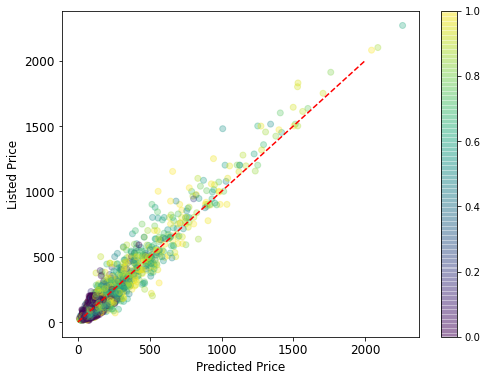

In [151]:
fig,ax = plt.subplots(figsize=(8,6));
normalized_availability = X_train.availability_90/90;
im = ax.scatter(gb_model2.predict(X_train),y_train,c=normalized_availability,alpha=0.3);
ax.plot([0,2000],[0,2000],ls='--',color='r');
ax.set_xlabel('Predicted Price');
ax.set_ylabel('Listed Price');
fig.colorbar(im, ax=ax);
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels() ):
        item.set_fontsize(12)

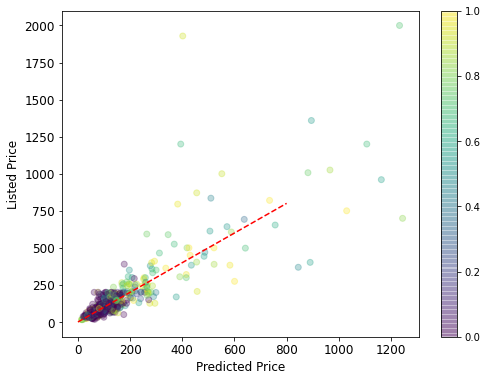

In [152]:
fig,ax = plt.subplots(figsize=(8,6));
normalized_availability = X_test.availability_90/90;
im = ax.scatter(gb_model2.predict(X_test),y_test,c=normalized_availability,alpha=0.3);
ax.plot([0,800],[0,800],ls='--',color='r');
ax.set_xlabel('Predicted Price');
ax.set_ylabel('Listed Price');
fig.colorbar(im, ax=ax);
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels() ):
        item.set_fontsize(12)

In [153]:
np.sqrt(mean_squared_error(y_train,gb_model2.predict(X_train)))

50.676171921969214

In [154]:
np.sqrt(mean_squared_error(y_test,gb_model2.predict(X_test)))

118.40075876412986

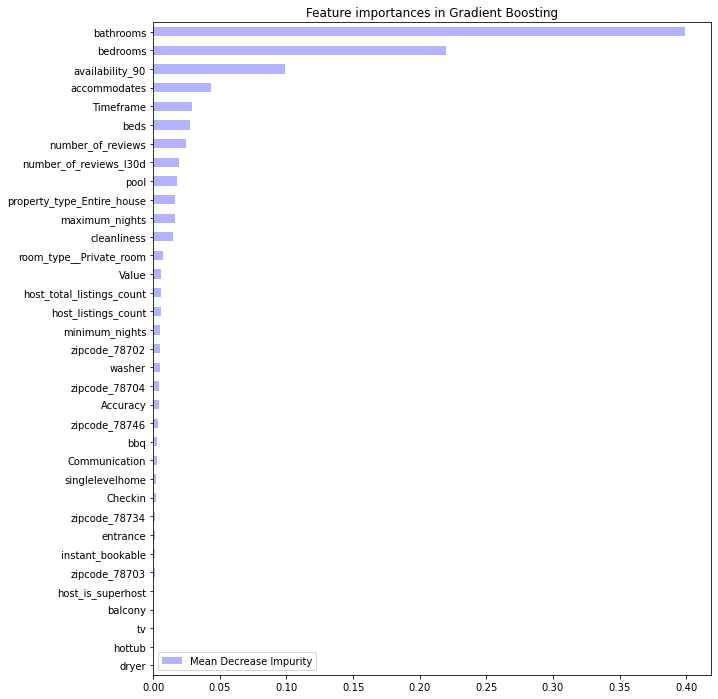

In [155]:
feature_scores = pd.DataFrame({'Mean Decrease Impurity' : gb_model2.feature_importances_}, index=X_train.columns)
feature_scores = feature_scores.sort_values(by='Mean Decrease Impurity', ascending=False)
ax = feature_scores.plot(kind='barh', color = 'b', alpha=0.3,figsize=(10,12) )
plt.gca().invert_yaxis()   # higher value on the top of the plot
ax.set_title('Feature importances in Gradient Boosting');